# Constructing a game

Example: "Stripped-Down Poker"

There are two players, **Alice** and **Bob**, and a deck of cards, with equal numbers of **King** and **Queen** cards.

1. The game begins with each player putting \$1 in the pot.
    - A card is dealt at random to Alice.
    - Alice observes her card.
    - Bob does not observe the card.
2. Alice then chooses either to **Bet** or to **Fold**.
    - If she chooses to Fold, Bob wins the pot and the game ends.
    - If she chooses to Bet, she adds another \$1 to the pot.
3. If Alice Bet, Bob then chooses either to **Call** or **Fold**.
    - If he chooses to Fold, Alice wins the pot and the game ends.
    - If he chooses to Call, he adds another $1 to the pot.
4. There is then a showdown, in which Alice reveals her card.
    - If she has a King, then she wins the pot.
    - If she has a Queen, then Bob wins the pot.

In [1]:
from draw_tree import draw_tree
import pygambit as gbt

In [2]:
g = gbt.Game.new_tree(
    players=["Alice", "Bob"],
    title="Stripped-Down Poker: a simple game of one-card poker from Reiley et al (2008)."
)

In [3]:
print(g.players["Alice"])
print(g.players["Bob"])
print(g.players.chance)

Player(game=Game(title='Stripped-Down Poker: a simple game of one-card poker from Reiley et al (2008).'), label='Alice')
Player(game=Game(title='Stripped-Down Poker: a simple game of one-card poker from Reiley et al (2008).'), label='Bob')
ChancePlayer(game=Game(title='Stripped-Down Poker: a simple game of one-card poker from Reiley et al (2008).'))


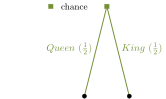

In [4]:
g.append_move(
    g.root,
    player=g.players.chance,
    actions=["King", "Queen"]
)
g.set_chance_probs(g.root.infoset, ["1/2", "1/2"])
draw_tree(g, color_scheme="gambit")

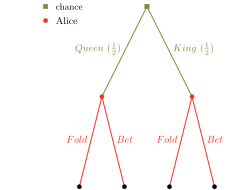

In [5]:
for node in g.root.children:
    g.append_move(
        node,
        player="Alice",
        actions=["Bet", "Fold"]
    )
draw_tree(g, color_scheme="gambit")

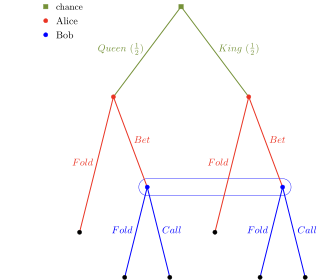

In [6]:
g.append_move(
    [g.root.children["King"].children["Bet"], g.root.children["Queen"].children["Bet"]],
    player="Bob",
    actions=["Call", "Fold"]
)
draw_tree(g, color_scheme="gambit")

In [7]:
win_big = g.add_outcome([2, -2], label="Win Big")
win = g.add_outcome([1, -1], label="Win")
lose_big = g.add_outcome([-2, 2], label="Lose Big")
lose = g.add_outcome([-1, 1], label="Lose")

In [8]:
# Alice folds, Bob wins small
g.set_outcome(g.root.children["King"].children["Fold"], lose)
g.set_outcome(g.root.children["Queen"].children["Fold"], lose)

# Bob sees Alice Bet and calls, correctly believing she is bluffing, Bob wins big
g.set_outcome(g.root.children["Queen"].children["Bet"].children["Call"], lose_big)

# Bob sees Alice Bet and calls, incorrectly believing she is bluffing, Alice wins big
g.set_outcome(g.root.children["King"].children["Bet"].children["Call"], win_big)

# Bob does not call Alice's Bet, Alice wins small
g.set_outcome(g.root.children["King"].children["Bet"].children["Fold"], win)
g.set_outcome(g.root.children["Queen"].children["Bet"].children["Fold"], win)

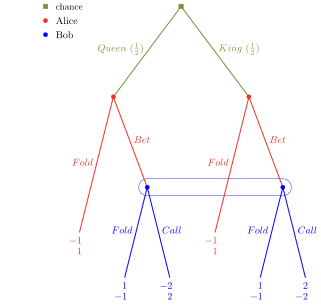

In [9]:
draw_tree(g, color_scheme="gambit")

# Nash equilibria

- Equilibria are stable situations when no player has an incentive to deviate their strategy
- `lcp_solve` computes Nash equilibria by finding solutions to a linear complementarity problem

In [10]:
result = gbt.nash.lcp_solve(g)
result

NashComputationResult(method='lcp', rational=True, use_strategic=False, equilibria=[[[[Rational(1, 1), Rational(0, 1)], [Rational(1, 3), Rational(2, 3)]], [[Rational(2, 3), Rational(1, 3)]]]], parameters={'stop_after': None, 'max_depth': None})

In [11]:
print("Number of equilibria found:", len(result.equilibria))
eqm = result.equilibria[0]

Number of equilibria found: 1


In [12]:
type(eqm["Alice"])

pygambit.gambit.MixedBehavior

A mixed behavior profile specifies, for each information set, the probability distribution over actions at that information set.

In [13]:
eqm["Alice"]

[[Rational(1, 1), Rational(0, 1)], [Rational(1, 3), Rational(2, 3)]]

These are the probabilities that Alice takes each of her available actions dependent on whether a King or Queen was dealt:

In [14]:
for action in g.players["Alice"].actions:
    print(
        f"At information set {action.infoset.number}, "
        f"Alice plays {action.label} with probability: {eqm[action]}"
    )

At information set 0, Alice plays Bet with probability: 1
At information set 0, Alice plays Fold with probability: 0
At information set 1, Alice plays Bet with probability: 1/3
At information set 1, Alice plays Fold with probability: 2/3


In [15]:
eqm["Bob"]

[[Rational(2, 3), Rational(1, 3)]]

In [16]:
for action in g.players["Bob"].actions:
    print(
        f"At information set {action.infoset.number}, "
        f"Bob plays {action.label} with probability: {eqm[action]}"
    )

At information set 0, Bob plays Call with probability: 2/3
At information set 0, Bob plays Fold with probability: 1/3


# OpenSpiel

In [17]:
import pyspiel
import numpy as np

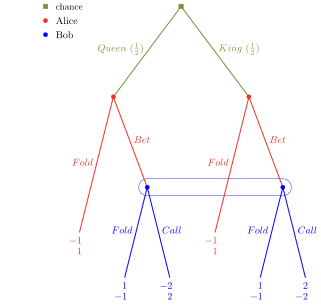

In [18]:
draw_tree(g, color_scheme="gambit")

In [19]:
ops_g = pyspiel.load_efg_game(g.to_efg())
ops_g

efg_game()

A single playthrough of the game:

In [20]:
players = {0: "Alice", 1: "Bob", -1: "Chance"}

# Create an initial game state, then play through to completion
state = ops_g.new_initial_state()
while not state.is_terminal():

  # Store legal actions of current player in a dict
  legal_actions = {}
  for action in state.legal_actions():
    legal_actions[action] = state.action_to_string(state.current_player(), action)

  # If player is chance, choose an action according to probability
  if state.is_chance_node():
    outcomes_with_probs = state.chance_outcomes()
    action_list, prob_list = zip(*outcomes_with_probs)
    action = np.random.choice(action_list, p=prob_list)
    print("Dealt card: ", legal_actions[action])
    state.apply_action(action)

  # Regular players pick a random legal action.
  else:
    action = np.random.choice(state.legal_actions())
    print(players[state.current_player()], " action: ", legal_actions[action])
    state.apply_action(action)
  print()

print("Alice receives: ", state.player_return(0), ", Bob receives: ", state.player_return(1))

Dealt card:  King

Alice  action:  Bet

Bob  action:  Call

Alice receives:  2.0 , Bob receives:  -2.0


OpenSpiel can be used to train reinforcement learning agents via self-play.

Player strategies can improve over time and may eventually reach equilibria (including for larger games than Gambit's algorithm's can handle).

# Converging to equilibria

Let's see how we can find an equilibrium of player strategies for a simpler one step Rock-Paper-Scissors game.

In [21]:
# Load the game from OpenSpiel
ops_matrix_rps_game = pyspiel.load_game("matrix_rps")

# Create the game in pygambit
from io import StringIO
nfg_matrix_rps_game = pyspiel.game_to_nfg_string(ops_matrix_rps_game)
gbt_matrix_rps_game = gbt.read_nfg(StringIO(nfg_matrix_rps_game))

gbt_matrix_rps_game.title = "Rock-Paper-Scissors"

for player in gbt_matrix_rps_game.players:
    player.strategies[0].label = "Rock"
    player.strategies[1].label = "Paper"
    player.strategies[2].label = "Scissors"

gbt_matrix_rps_game

,Rock,Paper,Scissors
Rock,"0,0","-1,1","1,-1"
Paper,"1,-1","0,0","-1,1"
Scissors,"-1,1","1,-1","0,0"


In [31]:
state = ops_matrix_rps_game.new_initial_state()
# Simulate Rock vs Paper
state.apply_actions([0, 1])
state.rewards()

[-1.0, 1.0]

In [23]:
gbt.nash.lcp_solve(gbt_matrix_rps_game).equilibria[0]

[[Rational(1, 3), Rational(1, 3), Rational(1, 3)], [Rational(1, 3), Rational(1, 3), Rational(1, 3)]]

In **replicator dynamics**, a pure strategy (e.g. always play "Rock") that performs well against others will increase in frequency, while strategies performing worse will decrease. In our rock-paper-scissors example, the performance of each pure strategy (action) depends on the probability it is assigned in the mixed strategy profile. At the start, whilst there are more players choosing scissors as their action, then rock will perform well and increase in frequency (be more likely to get played in subsequent rounds), while paper will perform poorly and decrease in frequency. We can plot how the frequency of each strategy changes over time:

In [24]:
from open_spiel.python.egt import dynamics
from open_spiel.python.egt.utils import game_payoffs_array
import matplotlib.pyplot as plt

matrix_rps_payoffs = game_payoffs_array(ops_matrix_rps_game)
dyn = dynamics.SinglePopulationDynamics(matrix_rps_payoffs, dynamics.replicator)

def plot_rps_dynamics(proportions, steps=100, alpha=0.1, plot_average_strategy=False):
    x = np.array(proportions)
    rock_proportions = [x[0]]
    paper_proportions = [x[1]]
    scissors_proportions = [x[2]]
    y = []
    for _ in range(steps):
        x += alpha * dyn(x)
        rock_proportions.append(x[0])
        paper_proportions.append(x[1])
        scissors_proportions.append(x[2])
        if plot_average_strategy:
            y.append([np.mean(rock_proportions),
                      np.mean(paper_proportions),
                      np.mean(scissors_proportions)
                      ])
        else:
            y.append(x.copy())
    y = np.array(y)

    plt.plot(y[:, 0], label="Rock")
    plt.plot(y[:, 1], label="Paper")
    plt.plot(y[:, 2], label="Scissors")
    plt.xlabel("Time step")
    if plot_average_strategy:
        plt.ylabel("Strategy frequency average up to time step")
    else:
        plt.ylabel("Strategy frequency")
    plt.legend()
    plt.show()

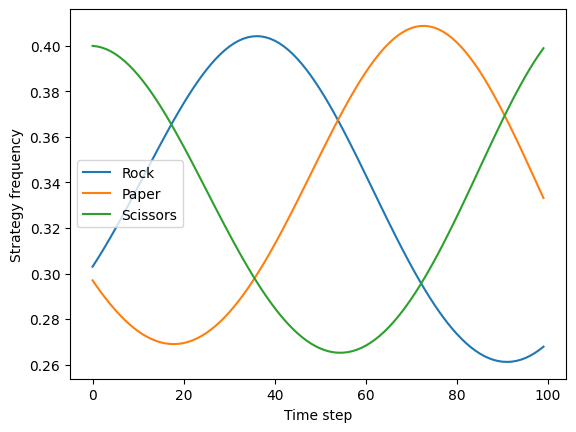

In [25]:
plot_rps_dynamics([0.3, 0.3, 0.4])

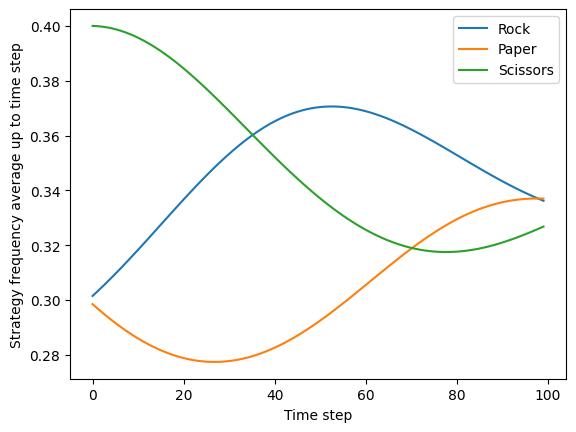

In [26]:
plot_rps_dynamics([0.3, 0.3, 0.4], plot_average_strategy=True)

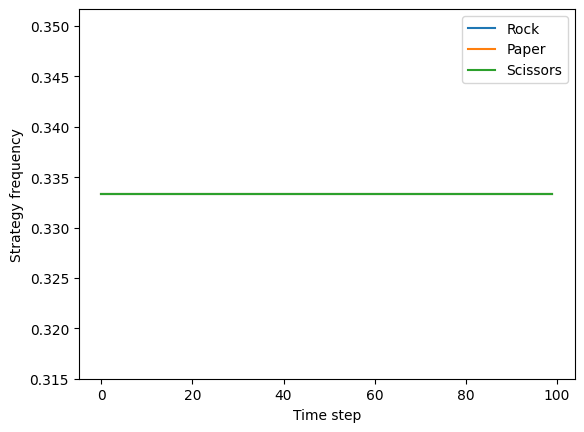

In [27]:
plot_rps_dynamics([1/3, 1/3, 1/3])